In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seizure-pre/p15_Record2.edf
/kaggle/input/seizure-pre/p11_Record4.edf
/kaggle/input/seizure-pre/p15_Record3.edf
/kaggle/input/seizure-pre/p10_Record1.edf
/kaggle/input/seizure-pre/p14_Record2.edf
/kaggle/input/seizure-pre/p14_Record3.edf
/kaggle/input/seizure-pre/p12_Record2.edf
/kaggle/input/seizure-pre/p12_Record3.edf
/kaggle/input/seizure-pre/p12_Record1.edf
/kaggle/input/seizure-pre/p11_Record2.edf
/kaggle/input/seizure-pre/p10_Record2.edf
/kaggle/input/seizure-pre/p14_Record1.edf
/kaggle/input/seizure-pre/p13_Record3.edf
/kaggle/input/seizure-pre/p15_Record4.edf
/kaggle/input/seizure-pre/p11_Record3.edf
/kaggle/input/seizure-pre/p15_Record1.edf
/kaggle/input/seizure-pre/p13_Record1.edf
/kaggle/input/seizure-pre/p13_Record4.edf
/kaggle/input/seizure-pre/Seizures_Information.xlsx
/kaggle/input/seizure-pre/p11_Record1.edf
/kaggle/input/seizure-pre/p13_Record2.edf


In [23]:
pip install pyedflib imbalanced-learn lightgbm

Note: you may need to restart the kernel to use updated packages.


Data Building

In [24]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import mne
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib

# -----------------------------
# 1. Duration and Time Helpers
# -----------------------------
def convert_duration(duration_str):
    try:
        duration_str = str(duration_str).lower().replace(" ", "").replace(",", "")
        minutes = seconds = 0
        if "min" in duration_str:
            parts = duration_str.split("min")
            minutes = int(parts[0]) if parts[0].isdigit() else 0
            duration_str = parts[1] if len(parts) > 1 else ""
        if "sec" in duration_str:
            sec_str = duration_str.replace("sec", "")
            seconds = int(sec_str) if sec_str.isdigit() else 0
        return minutes * 60 + seconds
    except:
        return None

def time_to_seconds_since_start(file_onset, event_time):
    try:
        if pd.isna(file_onset) or pd.isna(event_time):
            return None
        fmt = "%H:%M:%S"  # 24-hour format
        start = datetime.strptime(str(file_onset).strip(), fmt)
        event = datetime.strptime(str(event_time).strip(), fmt)
        delta = (event - start).total_seconds()
        if delta < 0:
            delta += 86400
        return int(delta)
    except Exception as e:
        print(f"⚠️ Time parsing failed: '{file_onset}' / '{event_time}' → {e}")
        return None

# -----------------------------
# 2. Parse Excel
# -----------------------------
def parse_excel(xls_path):
    df = pd.read_excel(xls_path, skiprows=2)
    df.columns = df.columns.str.strip()
    df.ffill(inplace=True)

    seizure_data = []
    for idx, row in df.iterrows():
        try:
            edf_file = str(row['File Name']).strip() + ".edf"
            file_onset = row['File onset']
            file_offset = row['File Offset']
            seizure_onset = row['Seizure onset']
            duration_str = row['Duration']

            if pd.isna(seizure_onset) or pd.isna(duration_str):
                continue

            duration_sec = convert_duration(duration_str)
            if duration_sec is None:
                continue

            seizure_start_sec = time_to_seconds_since_start(file_onset, seizure_onset)
            if seizure_start_sec is None:
                continue

            seizure_end_sec = seizure_start_sec + duration_sec
            recording_end = time_to_seconds_since_start(file_onset, file_offset)
            if recording_end is None:
                continue

            seizure_data.append({
                "edf_file": edf_file,
                "recording_start": 0,
                "recording_end": recording_end,
                "seizure_start": seizure_start_sec,
                "seizure_end": seizure_end_sec,
                "preseizure_start": max(seizure_start_sec - 900, 0)
            })
        except Exception as e:
            print(f"⚠️ Row {idx} error: {e}")
            continue

    return seizure_data

# -----------------------------
# 3. Read & Extract EDF with MNE
# -----------------------------
def extract_channels_mne(file_path, channels=4):
    try:
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        data, times = raw.get_data(return_times=True)
        return data[:channels]  # Take first `channels` EEG
    except Exception as e:
        print(f"❌ MNE EDF load failed: {file_path} → {e}")
        return None

from scipy.signal import welch
from scipy.stats import entropy as scipy_entropy
import pywt

def extract_features(signal, fs=500):
    feats = []

    for ch in signal:
        mean_val = np.mean(ch)
        std_val = np.std(ch)
        min_val = np.min(ch)
        max_val = np.max(ch)
        q25 = np.percentile(ch, 25)
        q75 = np.percentile(ch, 75)

        freqs, psd = welch(ch, fs=fs)
        band_power = lambda fmin, fmax: np.sum(psd[(freqs >= fmin) & (freqs < fmax)])
        delta = band_power(0.5, 4)
        theta = band_power(4, 8)
        alpha = band_power(8, 13)
        beta = band_power(13, 30)
        gamma = band_power(30, 45)

        hist, _ = np.histogram(ch, bins=50, density=True)
        hist += 1e-12
        shannon = -np.sum(hist * np.log2(hist))

        coeffs = pywt.wavedec(ch, 'db4', level=3)
        wavelet_energies = [np.sum(np.square(c)) for c in coeffs]

        feats.extend([
            mean_val, std_val, min_val, max_val, q25, q75,
            delta, theta, alpha, beta, gamma,
            shannon, *wavelet_energies
        ])

    return feats

def segment_and_extract(data, info, fs=500, window_sec=10):
    window_size = fs * window_sec
    total_windows = data.shape[1] // window_size
    X, y = [], []

    for i in range(total_windows):
        start = i * window_size
        end = start + window_size
        global_time = info["recording_start"] + start // fs

        if info["seizure_start"] <= global_time < info["seizure_end"]:
            label = 2
        elif info["preseizure_start"] <= global_time < info["seizure_start"]:
            label = 1
        else:
            label = 0

        segment = data[:, start:end]
        X.append(extract_features(segment))
        y.append(label)

    return np.array(X), np.array(y)

# -----------------------------
# 4. Dataset Builder
# -----------------------------
def build_dataset(summary_data, edf_folder):
    X_all, y_all = [], []
    for info in summary_data:
        edf_path = os.path.join(edf_folder, info["edf_file"])
        if not os.path.exists(edf_path):
            print(f"⚠️ Missing EDF: {edf_path}")
            continue
        data = extract_channels_mne(edf_path)
        if data is None:
            continue
        try:
            X, y = segment_and_extract(data, info)
            X_all.append(X)
            y_all.append(y)
        except Exception as e:
            print(f"❌ Error in {info['edf_file']}: {e}")
    if not X_all:
        return None, None
    return np.concatenate(X_all), np.concatenate(y_all)


**Random Forest**

In [25]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def train_random_forest(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # ⚖️ Use SMOTE with controlled sampling
    smote = SMOTE(sampling_strategy={0: 37621, 1: 37621, 2: 37621}, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # 🔀 Split data
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # 🌲 Random Forest with regularization
    clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        class_weight='balanced_subsample',
        random_state=42
    )

    # 🏋️‍♂️ Train
    clf.fit(X_train, y_train)

    # 📈 Training Evaluation
    print("\n📈 Training Set Evaluation")
    print(classification_report(
        y_train, clf.predict(X_train),
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # ✅ Validation Evaluation
    print("\n✅ Validation Report")
    print(classification_report(
        y_val, clf.predict(X_val),
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # 🧪 Final Test
    y_test_pred = clf.predict(X_test)
    print("\n🧪 Test Report")
    print(classification_report(
        y_test, y_test_pred,
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # 🔍 Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Non-Seizure", "Pre-Seizure", "Seizure"],
                yticklabels=["Non-Seizure", "Pre-Seizure", "Seizure"])
    plt.title("Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # 💾 Save model
    joblib.dump(clf, "random_forest_model.pkl")
    print("💾 Model saved as random_forest_model.pkl")


📁 Reading seizure metadata from: /kaggle/input/seizure-pre/Seizures_Information.xlsx
📊 Total seizure windows parsed: 40


/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipyk

✅ Final dataset: 41540 samples, 64 features

📊 Original label distribution: [37621  3349   570]
✅ After SMOTE label distribution: [37621 37621 37621]

📈 Training Set Evaluation
              precision    recall  f1-score   support

 Non-Seizure       0.98      0.89      0.93     27087
 Pre-Seizure       0.90      0.98      0.94     27087
     Seizure       0.99      1.00      1.00     27086

    accuracy                           0.96     81260
   macro avg       0.96      0.96      0.96     81260
weighted avg       0.96      0.96      0.96     81260


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.93      0.83      0.88      6772
 Pre-Seizure       0.85      0.94      0.89      6772
     Seizure       0.99      1.00      0.99      6772

    accuracy                           0.92     20316
   macro avg       0.92      0.92      0.92     20316
weighted avg       0.92      0.92      0.92     20316


🧪 Test Report
              precision  

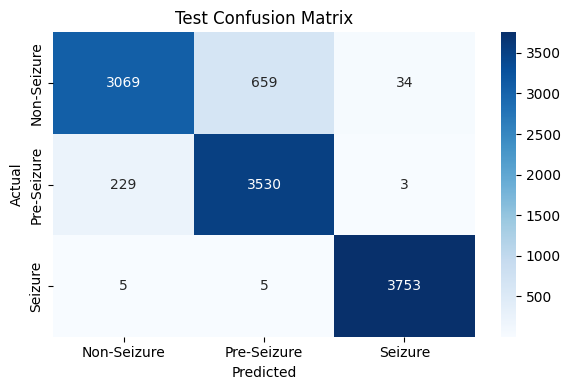

💾 Model saved as random_forest_model.pkl


In [26]:
# -----------------------------
# 7. Run the Pipeline
# -----------------------------
if __name__ == "__main__":
    excel_path = "/kaggle/input/seizure-pre/Seizures_Information.xlsx"
    edf_folder = "/kaggle/input/seizure-pre"

    print(f"📁 Reading seizure metadata from: {excel_path}")
    summary_data = parse_excel(excel_path)
    print(f"📊 Total seizure windows parsed: {len(summary_data)}")

    X, y = build_dataset(summary_data, edf_folder)
    if X is not None:
        print(f"✅ Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
        train_random_forest(X, y)
    else:
        print("❌ Dataset build failed.")


**xgboost**

In [27]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [30]:
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np

def train_xgboost(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # ⚖️ Balance the classes
    smote = SMOTE(sampling_strategy={0: 37621, 1: 37621, 2: 37621}, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # 🔀 Split data
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # 🚀 XGBoost Classifier
    clf = XGBClassifier(
        objective='multi:softmax',
        num_class=3,
        eval_metric='mlogloss',
        n_estimators=300,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        random_state=42
    )

    # 🏋️‍♂️ Train
    clf.fit(X_train, y_train)

    # 📈 Training Evaluation
    print("\n📈 Training Set Evaluation")
    print(classification_report(
        y_train, clf.predict(X_train),
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # ✅ Validation Evaluation
    print("\n✅ Validation Report")
    print(classification_report(
        y_val, clf.predict(X_val),
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # 🧪 Test Evaluation
    y_test_pred = clf.predict(X_test)
    print("\n🧪 Test Report")
    print(classification_report(
        y_test, y_test_pred,
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # 🔍 Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=["Non-Seizure", "Pre-Seizure", "Seizure"],
                yticklabels=["Non-Seizure", "Pre-Seizure", "Seizure"])
    plt.title("XGBoost Test Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # 💾 Save model
    joblib.dump(clf, "xgboost_model.pkl")
    print("💾 Model saved as xgboost_model.pkl")


📁 Reading seizure metadata from: /kaggle/input/seizure-pre/Seizures_Information.xlsx
📊 Total seizure windows parsed: 40


/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipyk

✅ Final dataset: 41540 samples, 64 features

📊 Original label distribution: [37621  3349   570]
✅ After SMOTE label distribution: [37621 37621 37621]

📈 Training Set Evaluation
              precision    recall  f1-score   support

 Non-Seizure       0.96      0.86      0.91     27087
 Pre-Seizure       0.88      0.97      0.92     27087
     Seizure       0.99      1.00      1.00     27086

    accuracy                           0.94     81260
   macro avg       0.95      0.94      0.94     81260
weighted avg       0.95      0.94      0.94     81260


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.92      0.81      0.86      6772
 Pre-Seizure       0.84      0.93      0.88      6772
     Seizure       0.99      1.00      0.99      6772

    accuracy                           0.91     20316
   macro avg       0.92      0.91      0.91     20316
weighted avg       0.92      0.91      0.91     20316


🧪 Test Report
              precision  

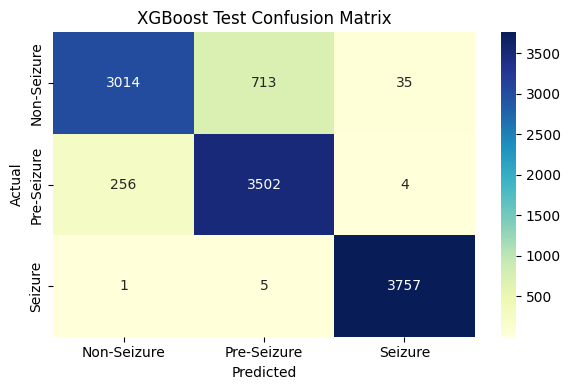

💾 Model saved as xgboost_model.pkl


In [31]:
# -----------------------------
# 7. Run the Pipeline
# -----------------------------
if __name__ == "__main__":
    excel_path = "/kaggle/input/seizure-pre/Seizures_Information.xlsx"
    edf_folder = "/kaggle/input/seizure-pre"

    print(f"📁 Reading seizure metadata from: {excel_path}")
    summary_data = parse_excel(excel_path)
    print(f"📊 Total seizure windows parsed: {len(summary_data)}")

    X, y = build_dataset(summary_data, edf_folder)
    if X is not None:
        print(f"✅ Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
        train_xgboost(X, y)
    else:
        print("❌ Dataset build failed.")


**LightGBM**

In [32]:
from lightgbm import early_stopping, log_evaluation
from lightgbm import LGBMClassifier

def train_lightgbm(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # ⚖️ Use SMOTE to balance the dataset
    smote = SMOTE(sampling_strategy={0: 37621, 1: 37621, 2: 37621}, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # 🔀 Train-validation-test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    
    # 🌟 LightGBM Classifier
    clf = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=15,
        num_leaves=31,
        class_weight='balanced',
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    # 🏋️‍♂️ Train model
    clf.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[early_stopping(stopping_rounds=30), log_evaluation(period=50)]
    )
    # 📈 Training evaluation
    print("\n📈 Training Set Evaluation")
    print(classification_report(
        y_train, clf.predict(X_train),
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # ✅ Validation evaluation
    print("\n✅ Validation Report")
    print(classification_report(
        y_val, clf.predict(X_val),
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # 🧪 Test evaluation
    y_test_pred = clf.predict(X_test)
    print("\n🧪 Test Report")
    print(classification_report(
        y_test, y_test_pred,
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # 🔍 Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=["Non-Seizure", "Pre-Seizure", "Seizure"],
                yticklabels=["Non-Seizure", "Pre-Seizure", "Seizure"])
    plt.title("Test Confusion Matrix - LightGBM")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # 💾 Save model
    joblib.dump(clf, "lightgbm_model.pkl")
    print("💾 Model saved as lightgbm_model.pkl")


📁 Reading seizure metadata from: /kaggle/input/seizure-pre/Seizures_Information.xlsx
📊 Total seizure windows parsed: 40


/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipyk

✅ Final dataset: 41540 samples, 64 features

📊 Original label distribution: [37621  3349   570]
✅ After SMOTE label distribution: [37621 37621 37621]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16320
[LightGBM] [Info] Number of data points in the train set: 81260, number of used features: 64
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.413468
[100]	valid_0's multi_logloss: 0.323793
[150]	valid_0's multi_logloss: 0.286091
[200]	valid_0's multi_logloss: 0.264278
[250]	valid_0's multi_logloss: 0.24604
[300]	valid_0's multi_logloss: 0.230443
[350]	valid_0's multi_logloss: 0.221181
[400]	valid_0's multi_logloss: 0.212572
[450]	valid_0's multi_logloss: 0.205881
[500]	valid_0's multi_logloss: 0.198236
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 0.198236



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

 Non-Seizure       0.96      0.91      0.93     27087
 Pre-Seizure       0.92      0.96      0.94     27087
     Seizure       1.00      1.00      1.00     27086

    accuracy                           0.96     81260
   macro avg       0.96      0.96      0.96     81260
weighted avg       0.96      0.96      0.96     81260


✅ Validation Report


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

 Non-Seizure       0.92      0.87      0.89      6772
 Pre-Seizure       0.88      0.92      0.90      6772
     Seizure       0.99      1.00      0.99      6772

    accuracy                           0.93     20316
   macro avg       0.93      0.93      0.93     20316
weighted avg       0.93      0.93      0.93     20316



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



🧪 Test Report
              precision    recall  f1-score   support

 Non-Seizure       0.92      0.85      0.89      3762
 Pre-Seizure       0.87      0.93      0.90      3762
     Seizure       0.99      1.00      0.99      3763

    accuracy                           0.93     11287
   macro avg       0.93      0.93      0.93     11287
weighted avg       0.93      0.93      0.93     11287



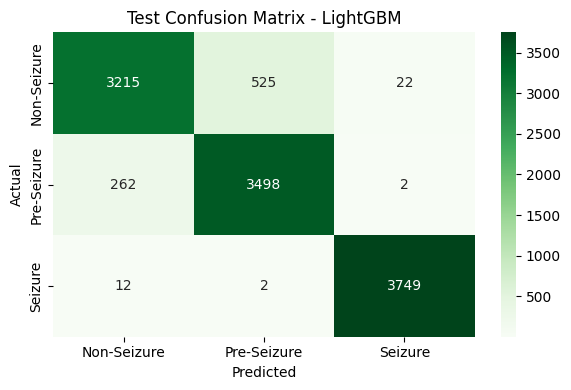

💾 Model saved as lightgbm_model.pkl


In [33]:
# -----------------------------
# 7. Run the Pipeline
# -----------------------------
if __name__ == "__main__":
    excel_path = "/kaggle/input/seizure-pre/Seizures_Information.xlsx"
    edf_folder = "/kaggle/input/seizure-pre"

    print(f"📁 Reading seizure metadata from: {excel_path}")
    summary_data = parse_excel(excel_path)
    print(f"📊 Total seizure windows parsed: {len(summary_data)}")

    X, y = build_dataset(summary_data, edf_folder)
    if X is not None:
        print(f"✅ Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
        train_lightgbm(X, y)
    else:
        print("❌ Dataset build failed.")


**Stacking**

In [34]:
import joblib
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

def stacking_ensemble(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # ⚖️ Apply SMOTE
    smote = SMOTE(sampling_strategy={0: 37621, 1: 37621, 2: 37621}, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE:", np.bincount(y_res))

    # 🔀 Split dataset
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # 💾 Load base models
    rf = joblib.load("random_forest_model.pkl")
    xgb = joblib.load("xgboost_model.pkl")
    lgb = joblib.load("lightgbm_model.pkl")

    # 🔮 Get base model predictions for training meta-model
    rf_train_pred = rf.predict(X_val).reshape(-1, 1)
    xgb_train_pred = xgb.predict(X_val).reshape(-1, 1)
    lgb_train_pred = lgb.predict(X_val).reshape(-1, 1)

    meta_X_train = np.hstack((rf_train_pred, xgb_train_pred, lgb_train_pred))
    meta_y_train = y_val

    # 🧠 Train meta-model
    meta_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    meta_model.fit(meta_X_train, meta_y_train)

    # 📈 Evaluate on training set (stacking part)
    rf_train_pred = rf.predict(X_train).reshape(-1, 1)
    xgb_train_pred = xgb.predict(X_train).reshape(-1, 1)
    lgb_train_pred = lgb.predict(X_train).reshape(-1, 1)
    meta_X_train_full = np.hstack((rf_train_pred, xgb_train_pred, lgb_train_pred))
    final_train_pred = meta_model.predict(meta_X_train_full)

    
    print("\n📈 Stacking Ensemble - Training Report")
    print(classification_report(
        y_train, final_train_pred,
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # 🧪 Test predictions
    rf_test_pred = rf.predict(X_test).reshape(-1, 1)
    xgb_test_pred = xgb.predict(X_test).reshape(-1, 1)
    lgb_test_pred = lgb.predict(X_test).reshape(-1, 1)
    meta_X_test = np.hstack((rf_test_pred, xgb_test_pred, lgb_test_pred))
    final_test_pred = meta_model.predict(meta_X_test)

    print("\n🧪 Stacking Ensemble - Test Report")
    print(classification_report(
        y_test, final_test_pred,
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # 🔍 Confusion Matrix
    cm = confusion_matrix(y_test, final_test_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=["Non-Seizure", "Pre-Seizure", "Seizure"],
                yticklabels=["Non-Seizure", "Pre-Seizure", "Seizure"])
    plt.title("Stacking Ensemble  - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


📁 Reading seizure metadata from: /kaggle/input/seizure-pre/Seizures_Information.xlsx
📊 Total seizure windows parsed: 40


/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipyk

✅ Final dataset: 41540 samples, 64 features

📊 Original label distribution: [37621  3349   570]
✅ After SMOTE: [37621 37621 37621]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



📈 Stacking Ensemble - Training Report
              precision    recall  f1-score   support

 Non-Seizure       0.96      0.93      0.94     27087
 Pre-Seizure       0.94      0.96      0.95     27087
     Seizure       0.99      1.00      1.00     27086

    accuracy                           0.96     81260
   macro avg       0.96      0.96      0.96     81260
weighted avg       0.96      0.96      0.96     81260



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



🧪 Stacking Ensemble - Test Report
              precision    recall  f1-score   support

 Non-Seizure       0.91      0.88      0.89      3762
 Pre-Seizure       0.89      0.91      0.90      3762
     Seizure       0.99      1.00      0.99      3763

    accuracy                           0.93     11287
   macro avg       0.93      0.93      0.93     11287
weighted avg       0.93      0.93      0.93     11287



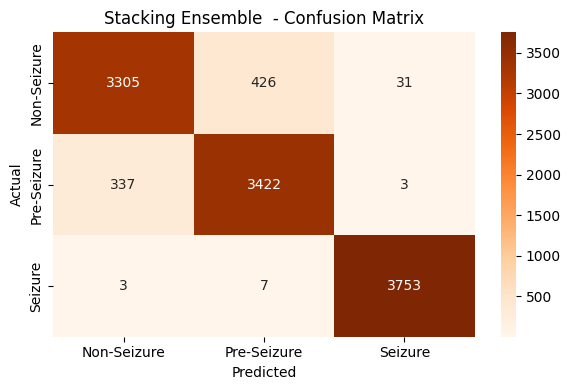

In [35]:
# -----------------------------
# 7. Run the Pipeline
# -----------------------------
if __name__ == "__main__":
    excel_path = "/kaggle/input/seizure-pre/Seizures_Information.xlsx"
    edf_folder = "/kaggle/input/seizure-pre"

    print(f"📁 Reading seizure metadata from: {excel_path}")
    summary_data = parse_excel(excel_path)
    print(f"📊 Total seizure windows parsed: {len(summary_data)}")

    X, y = build_dataset(summary_data, edf_folder)
    if X is not None:
        print(f"✅ Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
        stacking_ensemble(X, y)
    else:
        print("❌ Dataset build failed.")


**Bagging**

In [36]:
import joblib
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

def bagging_classifier_ensemble(X, y, n_estimators=10):
    print("\n📊 Original label distribution:", np.bincount(y))

    # ⚖️ Apply SMOTE
    smote = SMOTE(sampling_strategy={0: 37621, 1: 37621, 2: 37621}, random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE:", np.bincount(y_res))

    # 🔀 Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)

    # 🌲 Base estimator
    base_estimator = DecisionTreeClassifier(max_depth=24,random_state=42)

    # 🧠 Bagging Classifier
    bagging = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        max_samples=1.0,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    # 📦 Train
    bagging.fit(X_train, y_train)
    joblib.dump(bagging, "bagging_classifier_model.pkl")

    # 📈 Training Report
    train_preds = bagging.predict(X_train)
    print("\n📈 BaggingClassifier - Training Report")
    print(classification_report(
        y_train, train_preds,
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # 🧪 Test Report
    test_preds = bagging.predict(X_test)
    print("\n🧪 BaggingClassifier - Test Report")
    print(classification_report(
        y_test, test_preds,
        target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]
    ))

    # 🔍 Confusion Matrix
    cm = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=["Non-Seizure", "Pre-Seizure", "Seizure"],
                yticklabels=["Non-Seizure", "Pre-Seizure", "Seizure"])
    plt.title("BaggingClassifier - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


📁 Reading seizure metadata from: /kaggle/input/seizure-pre/Seizures_Information.xlsx
📊 Total seizure windows parsed: 40


/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipykernel_35/1637889572.py:100: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
/tmp/ipyk

✅ Final dataset: 41540 samples, 64 features

📊 Original label distribution: [37621  3349   570]
✅ After SMOTE: [37621 37621 37621]

📈 BaggingClassifier - Training Report
              precision    recall  f1-score   support

 Non-Seizure       0.97      0.92      0.95     33859
 Pre-Seizure       0.93      0.98      0.95     33859
     Seizure       1.00      1.00      1.00     33858

    accuracy                           0.96    101576
   macro avg       0.97      0.96      0.96    101576
weighted avg       0.97      0.96      0.96    101576


🧪 BaggingClassifier - Test Report
              precision    recall  f1-score   support

 Non-Seizure       0.92      0.86      0.89      3762
 Pre-Seizure       0.87      0.93      0.90      3762
     Seizure       0.99      0.99      0.99      3763

    accuracy                           0.93     11287
   macro avg       0.93      0.93      0.93     11287
weighted avg       0.93      0.93      0.93     11287



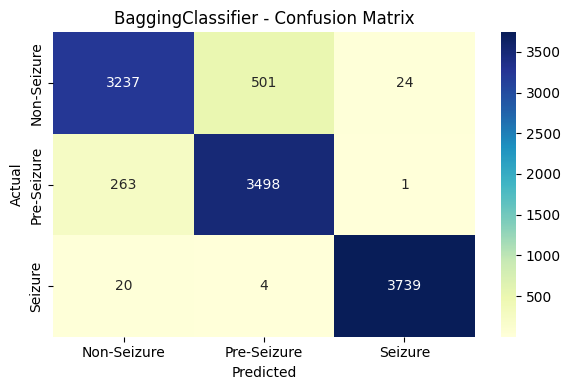

In [37]:
# -----------------------------
# 7. Run the Pipeline
# -----------------------------
if __name__ == "__main__":
    excel_path = "/kaggle/input/seizure-pre/Seizures_Information.xlsx"
    edf_folder = "/kaggle/input/seizure-pre"

    print(f"📁 Reading seizure metadata from: {excel_path}")
    summary_data = parse_excel(excel_path)
    print(f"📊 Total seizure windows parsed: {len(summary_data)}")

    X, y = build_dataset(summary_data, edf_folder)
    if X is not None:
        print(f"✅ Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
        bagging_classifier_ensemble(X, y)
    else:
        print("❌ Dataset build failed.")
